In [1]:
from build_model_and_dataset import *

After layer 1 : x.shape=torch.Size([1, 1])
After layer 2 : x.shape=torch.Size([1, 1])
After layer 3 : x.shape=torch.Size([1, 10])
Time to build the model: 0.04 seconds


In [2]:
MLP_model.skeleton, MLP_model.count_parameters()

({0: {'size': 50}, 1: {'size': 1}, 2: {'size': 1}, 3: {'size': 10}}, 73)

In [3]:
expe = str(5)
name_file_expe = 'results/StrategyOnAmplitudeFactor/' + expe + '/'

In [4]:
os.mkdir(name_file_expe)

In [5]:
MLP_model.how_to_define_batchsize

<function build_model_and_dataset.define_Batchsize(model, depth, method=None)>

In [6]:
to_add = [1, 2] # depths where we want to add neurons
nbr_steps_betw_adding = 0 # number of gradient step between each architecture growth

In [7]:
df_tracker = pd.DataFrame()
A_tr, A_te, L_tr, L_te, T = np.array([]), np.array([]), np.array([]), np.array([]), np.array([0])

In [8]:
def update_quantity_of_interest(method = 'Add', depth = 1) :
    global L_tr, L_te, A_tr, A_te, T, df_tracker
    X, Y = MLP_model.get_batch(indices=torch.arange(MLP_model.len_train_dataset))
    dico_DV = {'DV_norm_' + str(d) : np.sqrt((MLP_model.deplacement_voulu(d, X=X, Y = Y).norm()**2 / X.shape[0]).item()) for d in [1, 2, 3]}
    
    if method == 'Add' :
        #DV = MLP_model.deplacement_voulu(depth, X=X, Y = Y)
        dico_tracker = {'vps' + str(i) : [ MLP_model.valeurs_propres[i].item()] for i in range(len(MLP_model.valeurs_propres))}
        dico_tracker.update({'depth_add' : depth, 'nbr_added_neuron': MLP_model.nbr_added_neuron,
                        'sum_vps_sq' : (MLP_model.valeurs_propres ** 2).sum().item(),
                        'count': count, 'DV_proj_norm_sq': MLP_model.DV_proj_norm_sq.item()})

    elif method == 'NG' : 
        #DV = MLP_model.deplacement_voulu(depth + 1, X=X, Y = Y)
        dico_tracker = {}
        dico_tracker.update({'depth_NG' : depth, 'nbr_added_neuron': MLP_model.nbr_added_neuron,
                        'count': count})
    else:
        assert False
        
    dico_tracker.update({
        #'accroissement' : [dico_EB[best_depth]['accroissement']], 'portion_gain' : [dico_EB[best_depth]['portion_gain']],
                        'nbr_parameters_apres' : [MLP_model.count_parameters()], 'nbr_parameters_avant' : [nbr_parameters_avant],
                        'T' : [T[-1]], 'len_L_tr' : [len(L_tr)], 'lu_conv' : [MLP_model.lu_conv],
                        'size_layer_1' : [MLP_model.skeleton[1]['size']], 'size_layer_2' : [MLP_model.skeleton[2]['size']]})
    dico_tracker.update(dico_DV)
    df_tracker = pd.concat([df_tracker, pd.DataFrame.from_dict(dico_tracker)], ignore_index=True)
    
    L_tr = np.concatenate([L_tr, l_tr.unsqueeze(0)])
    L_te = np.concatenate([L_te, l_te.unsqueeze(0)])
    A_tr = np.concatenate([A_tr, a_tr.unsqueeze(0)])
    A_te = np.concatenate([A_te, a_te.unsqueeze(0)])
    #T = np.concatenate([T, t.unsqueeze(0) +  T[-1]])
    T = np.zeros(L_tr.shape[0] +1)
    
    
def AugBatchSizeLearning() :
    MLP_model.batch_size = math.ceil(np.sqrt(MLP_model.count_parameters() / nbr_parameters_avant) *  MLP_model.batch_size)
    #MLP_model.batch_size = math.ceil(MLP_model.count_parameters() / nbr_parameters_avant *  MLP_model.batch_size)

In [9]:
def compute_Loss_full(model):
    """
    Computes the avearged and individual losses of the network for a minibatch 
    either when adding the BestUpdate or the Newneurons, 
    with the amplitude factor 'ampl_fact'.
    """
    indx = torch.arange(model.len_train_dataset)
    L_tr = torch.tensor(0., device = my_device)
    A_tr = torch.tensor(0., device = my_device)
    for sous_indices in range(math.ceil(indx.shape[0]/model.max_batch_estimation)) :
        sous_ind = indx[sous_indices * model.max_batch_estimation : (sous_indices + 1) * model.max_batch_estimation]
        sous_seed = model.seed_lmbda[sous_indices * model.max_batch_estimation : (sous_indices + 1) * model.max_batch_estimation]
        X, Y = model.get_batch(indices = sous_ind, seed = sous_seed[0], device = my_device_0)
        #l[sous_indices * model.max_batch_estimation : (sous_indices + 1) * model.max_batch_estimation] = model.Loss(fct_to_apply(X, depth = depth, lmbda = ampl_fact)[0], Y.to(my_device), reduction = 'none')
        with torch.no_grad() :
            Y_pred = model(X)
        L_tr += model.Loss(Y_pred, Y, reduction = 'sum') /  indx.shape[0]
        A_tr += UTILS.calculate_accuracy(Y_pred, Y) * sous_ind.shape[0] / indx.shape[0]

    indx = torch.arange(model.len_test_dataset)
    L_te = torch.tensor(0., device = my_device)
    A_te = torch.tensor(0., device = my_device)

    for sous_indices in range(math.ceil(indx.shape[0]/model.max_batch_estimation)) :
        sous_ind = indx[sous_indices * model.max_batch_estimation : (sous_indices + 1) * model.max_batch_estimation]
        sous_seed = model.seed_lmbda[sous_indices * model.max_batch_estimation : (sous_indices + 1) * model.max_batch_estimation]
        X, Y = model.get_batch(indices = sous_ind, seed = sous_seed[0], device = my_device_0, data = 'te')
        #l[sous_indices * model.max_batch_estimation : (sous_indices + 1) * model.max_batch_estimation] = model.Loss(fct_to_apply(X, depth = depth, lmbda = ampl_fact)[0], Y.to(my_device), reduction = 'none')
        with torch.no_grad() :
            Y_pred = model(X)
        L_te += model.Loss(Y_pred, Y, reduction = 'sum') /  indx.shape[0]
        A_te += UTILS.calculate_accuracy(Y_pred, Y) * sous_ind.shape[0] / indx.shape[0]
    return(L_tr, L_te, A_tr, A_te) 

In [10]:
count = 1
t_0, t = 0, 0

In [11]:
for j in tqdm(range(50)) :

    ## search for the best depth to add the new neurons ##
    nbr_parameters_avant = MLP_model.count_parameters()
    gc.collect()
    torch.cuda.empty_cache()
    depth_ajout = to_add
    depth_in_decreasing_criterion, dico_EB = EB.where_is_EB_best_solved(MLP_model, depths = depth_ajout)

    best_depth = depth_in_decreasing_criterion[0]
    dico_EB_bd = dico_EB[best_depth]
    alpha, omega, bias_alpha, vps = dico_EB_bd['alpha'], dico_EB_bd['omega'], dico_EB_bd['bias_alpha'], dico_EB_bd['vps']
    lambda_method = dico_EB_bd['beta_min']

    MLP_model.alpha, MLP_model.omega, MLP_model.bias_alpha, MLP_model.valeurs_propres = None, None, None, torch.tensor([])
    MLP_model.TAB_Add = None


    if lambda_method > 0 :
        MLP_model.dico_w, MLP_model.lambda_method = dico_EB_bd['dico_w'], dico_EB_bd['beta_min']
        EB.add_neurons(MLP_model, best_depth, alpha = alpha, omega = omega, bias_alpha = bias_alpha, valeurs_propres = vps)
        MLP_model.lambda_method = torch.tensor(0., device = my_device_0)
    #########################################################


    l_tr, l_te, a_tr, a_te = compute_Loss_full(MLP_model)
    update_quantity_of_interest(method = 'Add', depth = best_depth)

    for depth in range(1, 4) :
        nbr_parameters_avant = MLP_model.count_parameters()
        gc.collect()
        MLP_model.dico_w = None
        MLP_model.how_to_define_batchsize(MLP_model, depth, method = 'NG')
        EB.compute_optimal_update(MLP_model, depth, update = True)

        l_tr, l_te, a_tr, a_te = compute_Loss_full(MLP_model)
        t = torch.tensor(time.time() - t_0, device = my_device)
        update_quantity_of_interest(method = 'NG', depth = depth)

    count += 1

    df_performance = pd.DataFrame.from_dict({'L_tr' : L_tr, 'L_te' : L_te, 'A_tr' : A_tr, 'A_te' : A_te, 'T' : T[1:], 
                                             'BatchSize' : np.ones(A_te.shape) * MLP_model.batch_size})
    df_tracker.to_csv(name_file_expe + '/df_tracker.csv')
    df_performance.to_csv(name_file_expe + '/df_performance.csv')
    MLP_model.T = T[-1]
    MLP_model.len_L_tr = len(L_tr)
    UTILS.save_model_to_file(MLP_model, path = name_file_expe + '/' , name='model_' + str(count))





  0%|          | 0/50 [00:00<?, ?it/s]



*** started  NG at  2 ***
Batch size for estimation : 500


*** started  Add at  1 ***
Batch size for estimation : 500
*** method : OUR ***
eigh succed
svd succed
*** ADD : THRESHOLD SELECTION ***
*** normalize NewNeurons acc. ||functional udpate|| ***
norm_x_over_norm_DE_depth: 1.457323670387268
norm_x_over_norm_DE_depthp1 :  4.395778656005859
(alpha, omega) <-- (-alpha, -omega)
Delta Loss :  [0.0, 0.0, 0.0]  ... [-0.04750466346740723, -0.07748246192932129, -0.09861373901367188]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.25, 0.5, 1.0]
rate of decrease : 0.03850938752293587 ampli_fct : 1.0 L[0] : 2.5607714653015137


*** started  NG at  3 ***
Batch size for estimation : 500


*** started  Add at  2 ***
Batch size for estimation : 500
*** method : OUR ***
eigh succed
svd succed
*** ADD : THRESHOLD SELECTION ***
*** normalize NewNeurons acc. ||functional udpate|| ***
norm_x_over_norm_DE_depth: 7.95474100112915
norm_x_over_norm_DE_depthp1 :  181.34007263183594


Delta Loss :  [0.0, 0.0, 0.0]  ... [-0.01576066017150879, -0.025192737579345703, -0.031048059463500977]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.25, 0.5, 1.0]
rate of decrease : 0.014469128102064133 ampli_fct : 1.0 L[0] : 2.1458141803741455
*** updated layer : 2 ***


*** started  NG at  3 ***
Batch size for estimation : 500
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, 0.0, 0.0]  ... [-0.01272130012512207, -0.017445802688598633, -0.002856016159057617]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.125, 0.25, 0.5]
rate of decrease : 0.00824951846152544 ampli_fct : 0.25 L[0] : 2.1147661209106445
*** updated layer : 3 ***


*** started  NG at  2 ***
Batch size for estimation : 500


*** started  Add at  1 ***
Batch size for estimation : 500
*** method : OUR ***
eigh succed
svd succed
*** ADD : THRESHOLD SELECTION ***
*** normalize NewNeurons acc. ||functional udpate|| ***
norm_x_over



*** started  NG at  1 ***
Batch size for estimation : 500
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, 1.1920928955078125e-07, 1.1920928955078125e-07]  ... [-0.012900352478027344, -0.01711559295654297, -0.008079886436462402]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.0625, 0.125, 0.25]
rate of decrease : 0.008686522953212261 ampli_fct : 0.125 L[0] : 1.9703617095947266
*** updated layer : 1 ***


*** started  NG at  2 ***
Batch size for estimation : 500
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, 0.0, 0.0]  ... [-0.005094408988952637, -0.006757616996765137, -0.002216815948486328]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.0625, 0.125, 0.25]
rate of decrease : 0.0034596852492541075 ampli_fct : 0.125 L[0] : 1.9532461166381836
*** updated layer : 2 ***


*** started  NG at  3 ***
Batch size for estimation : 500
*** NG : NO 



*** started  NG at  1 ***
Batch size for estimation : 500
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, 0.0, 0.0]  ... [-0.010219097137451172, -0.013848185539245605, -0.0069512128829956055]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.03125, 0.0625, 0.125]
rate of decrease : 0.007678964640945196 ampli_fct : 0.0625 L[0] : 1.8033922910690308
*** updated layer : 1 ***


*** started  NG at  2 ***
Batch size for estimation : 500
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, 0.0, 0.0]  ... [-0.0038056373596191406, -0.0050536394119262695, 0.00045800209045410156]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.03125, 0.0625, 0.125]
rate of decrease : 0.0028239814564585686 ampli_fct : 0.0625 L[0] : 1.7895441055297852
*** updated layer : 2 ***


*** started  NG at  3 ***
Batch size for estimation : 500
*** NG : NO SELECTION ***
*** normali



*** started  NG at  1 ***
Batch size for estimation : 500
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, 0.0, 0.0]  ... [-0.016916871070861816, -0.01778125762939453, 0.02021181583404541]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.03125, 0.0625, 0.125]
rate of decrease : 0.01073075458407402 ampli_fct : 0.0625 L[0] : 1.6570370197296143
*** updated layer : 1 ***


*** started  NG at  2 ***
Batch size for estimation : 500
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, 0.0, 0.0]  ... [-0.012076020240783691, -0.016159772872924805, -0.005781650543212891]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.03125, 0.0625, 0.125]
rate of decrease : 0.009857993572950363 ampli_fct : 0.0625 L[0] : 1.6392557621002197
*** updated layer : 2 ***


*** started  NG at  3 ***
Batch size for estimation : 500
*** NG : NO SELECTION ***
*** normalize BestUp



*** started  NG at  1 ***
Batch size for estimation : 500
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, -1.1920928955078125e-07, -1.1920928955078125e-07]  ... [-0.013755202293395996, -0.014678120613098145, 0.01703166961669922]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.015625, 0.03125, 0.0625]
rate of decrease : 0.009672976098954678 ampli_fct : 0.03125 L[0] : 1.517435908317566
*** updated layer : 1 ***


*** started  NG at  2 ***
Batch size for estimation : 500
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, 0.0, 0.0]  ... [-0.006054401397705078, -0.00801241397857666, 0.0003285408020019531]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.0078125, 0.015625, 0.03125]
rate of decrease : 0.005331806838512421 ampli_fct : 0.015625 L[0] : 1.5027577877044678
*** updated layer : 2 ***


*** started  NG at  3 ***
Batch size for estimation 



*** started  NG at  1 ***
Batch size for estimation : 500
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, 0.0, 0.0]  ... [-0.005389809608459473, -0.007342338562011719, -0.001569509506225586]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.00390625, 0.0078125, 0.015625]
rate of decrease : 0.005159586668014526 ampli_fct : 0.0078125 L[0] : 1.4230477809906006
*** updated layer : 1 ***


*** started  NG at  2 ***
Batch size for estimation : 500
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, -1.1920928955078125e-07, -1.1920928955078125e-07]  ... [-0.003541707992553711, -0.005171537399291992, -0.003123641014099121]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.00390625, 0.0078125, 0.015625]
rate of decrease : 0.0036529749631881714 ampli_fct : 0.0078125 L[0] : 1.415705680847168
*** updated layer : 2 ***


*** started  NG at  3 ***
Batch size



*** started  NG at  1 ***
Batch size for estimation : 500
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, 0.0, -1.1920928955078125e-07]  ... [-0.009484291076660156, -0.010399222373962402, 0.00859081745147705]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.00390625, 0.0078125, 0.015625]
rate of decrease : 0.0078120045363903046 ampli_fct : 0.0078125 L[0] : 1.3311848640441895
*** updated layer : 1 ***


*** started  NG at  2 ***
Batch size for estimation : 500
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, 0.0, 0.0]  ... [-0.006563305854797363, -0.008619189262390137, 0.0003134012222290039]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.001953125, 0.00390625, 0.0078125]
rate of decrease : 0.006525804754346609 ampli_fct : 0.00390625 L[0] : 1.320785641670227
*** updated layer : 2 ***


*** started  NG at  3 ***
Batch size for estimation : 



*** started  NG at  1 ***
Batch size for estimation : 500
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, 0.0, -1.1920928955078125e-07]  ... [-0.0141371488571167, -0.015423774719238281, 0.017189741134643555]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.00390625, 0.0078125, 0.015625]
rate of decrease : 0.01251602079719305 ampli_fct : 0.0078125 L[0] : 1.2323225736618042
*** updated layer : 1 ***


*** started  NG at  2 ***
Batch size for estimation : 500
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, 0.0, -1.1920928955078125e-07]  ... [-0.008565187454223633, -0.009958386421203613, 0.00792241096496582]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.001953125, 0.00390625, 0.0078125]
rate of decrease : 0.008183414116501808 ampli_fct : 0.00390625 L[0] : 1.216898798942566
*** updated layer : 2 ***


*** started  NG at  3 ***
Batch size fo



*** started  NG at  1 ***
Batch size for estimation : 500
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, 0.0, 0.0]  ... [-0.00965869426727295, -0.013437867164611816, -0.006607651710510254]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.001953125, 0.00390625, 0.0078125]
rate of decrease : 0.012223679572343826 ampli_fct : 0.00390625 L[0] : 1.0993307828903198
*** updated layer : 1 ***


*** started  NG at  2 ***
Batch size for estimation : 500
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, -1.1920928955078125e-07, -1.1920928955078125e-07]  ... [-0.006768703460693359, -0.007818460464477539, 0.006336212158203125]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.0009765625, 0.001953125, 0.00390625]
rate of decrease : 0.0072000292129814625 ampli_fct : 0.001953125 L[0] : 1.085892915725708
*** updated layer : 2 ***


*** started  NG at  3 ***




*** started  NG at  1 ***
Batch size for estimation : 500
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, -5.960464477539063e-08, 0.0]  ... [-0.012916386127471924, -0.017547786235809326, -0.004227995872497559]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.001953125, 0.00390625, 0.0078125]
rate of decrease : 0.017833981662988663 ampli_fct : 0.00390625 L[0] : 0.9839522838592529
*** updated layer : 1 ***


*** started  NG at  2 ***
Batch size for estimation : 500
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, 0.0, -1.7881393432617188e-07]  ... [-0.00699305534362793, -0.007208764553070068, 0.011506319046020508]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.0009765625, 0.001953125, 0.00390625]
rate of decrease : 0.007459366228431463 ampli_fct : 0.001953125 L[0] : 0.9664044380187988
*** updated layer : 2 ***


*** started  NG at  3 ***
B

norm_x_over_norm_DE_depth: 1.1595360040664673
norm_x_over_norm_DE_depthp1 :  2.0527029037475586
(alpha, omega) <-- (-alpha, -omega)
Delta Loss :  [0.0, -2.384185791015625e-07, -1.7881393432617188e-07]  ... [-0.0009719729423522949, -0.0013362765312194824, -0.00028121471405029297]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.0001220703125, 0.000244140625, 0.00048828125]
rate of decrease : 0.0015359154203906655 ampli_fct : 0.000244140625 L[0] : 0.8700196146965027


*** started  NG at  3 ***
Batch size for estimation : 500


*** started  Add at  2 ***
Batch size for estimation : 500
*** method : OUR ***
eigh succed
svd succed
*** ADD : THRESHOLD SELECTION ***
*** normalize NewNeurons acc. ||functional udpate|| ***
norm_x_over_norm_DE_depth: 22.717435836791992
norm_x_over_norm_DE_depthp1 :  396.0298767089844
(alpha, omega) <-- (-alpha, -omega)
Delta Loss :  [0.0, -5.960464477539063e-08, -5.960464477539063e-08]  ... [-0.0018562674522399902, -0.002795398235321045, -0.0



*** started  NG at  1 ***
Batch size for estimation : 500
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, -5.960464477539063e-08, -3.5762786865234375e-07]  ... [-0.009985744953155518, -0.010727643966674805, 0.011825323104858398]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.0009765625, 0.001953125, 0.00390625]
rate of decrease : 0.01382129080593586 ampli_fct : 0.001953125 L[0] : 0.7761680483818054
*** updated layer : 1 ***


*** started  NG at  2 ***
Batch size for estimation : 500
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, -1.1920928955078125e-07, -2.980232238769531e-07]  ... [-0.006517171859741211, -0.008995771408081055, -0.0024753808975219727]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.00048828125, 0.0009765625, 0.001953125]
rate of decrease : 0.011752411723136902 ampli_fct : 0.0009765625 L[0] : 0.7654404640197754
*** upd



*** started  NG at  1 ***
Batch size for estimation : 500
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, -1.7881393432617188e-07, -4.172325134277344e-07]  ... [-0.006629467010498047, -0.009179770946502686, -0.0029661059379577637]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.00048828125, 0.0009765625, 0.001953125]
rate of decrease : 0.0136719336733222 ampli_fct : 0.0009765625 L[0] : 0.6714317798614502
*** updated layer : 1 ***


*** started  NG at  2 ***
Batch size for estimation : 500
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, -1.1920928955078125e-07, -1.1920928955078125e-07]  ... [-0.0053005218505859375, -0.006626486778259277, 0.002724766731262207]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.00048828125, 0.0009765625, 0.001953125]
rate of decrease : 0.010005990974605083 ampli_fct : 0.0009765625 L[0] : 0.6622519493103027
**



*** started  NG at  1 ***
Batch size for estimation : 500
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, -5.960464477539063e-08, -5.960464477539063e-08]  ... [-0.007164418697357178, -0.010562241077423096, -0.00781095027923584]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.00048828125, 0.0009765625, 0.001953125]
rate of decrease : 0.020176373422145844 ampli_fct : 0.0009765625 L[0] : 0.5234954953193665
*** updated layer : 1 ***


*** started  NG at  2 ***
Batch size for estimation : 500
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, -1.1920928955078125e-07, -3.5762786865234375e-07]  ... [-0.006680428981781006, -0.008204519748687744, 0.004638016223907471]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.00048828125, 0.0009765625, 0.001953125]
rate of decrease : 0.015995293855667114 ampli_fct : 0.0009765625 L[0] : 0.5129333734512329
*** 



*** started  Add at  1 ***
Batch size for estimation : 500
*** method : OUR ***
eigh succed
svd succed
*** ADD : THRESHOLD SELECTION ***
*** normalize NewNeurons acc. ||functional udpate|| ***
norm_x_over_norm_DE_depth: 0.9625053405761719
norm_x_over_norm_DE_depthp1 :  1.39240562915802
(alpha, omega) <-- (-alpha, -omega)
Delta Loss :  [0.0, 0.0, -1.7881393432617188e-07]  ... [-0.0009901225566864014, -0.0010465383529663086, 0.0015457570552825928]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.0001220703125, 0.000244140625, 0.00048828125]
rate of decrease : 0.002513997256755829 ampli_fct : 0.000244140625 L[0] : 0.41628462076187134


*** started  NG at  3 ***
Batch size for estimation : 500


*** started  Add at  2 ***
Batch size for estimation : 500
*** method : OUR ***
eigh succed
svd succed
*** ADD : THRESHOLD SELECTION ***
*** normalize NewNeurons acc. ||functional udpate|| ***
norm_x_over_norm_DE_depth: 24.83812713623047
norm_x_over_norm_DE_depthp1 :  699.8642



*** started  NG at  1 ***
Batch size for estimation : 500
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, -1.1920928955078125e-07, -3.5762786865234375e-07]  ... [-0.009500265121459961, -0.012084245681762695, 0.0024597346782684326]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.00048828125, 0.0009765625, 0.001953125]
rate of decrease : 0.03906894475221634 ampli_fct : 0.0009765625 L[0] : 0.30930566787719727
*** updated layer : 1 ***


*** started  NG at  2 ***
Batch size for estimation : 500
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, -2.086162567138672e-07, -4.172325134277344e-07]  ... [-0.009500294923782349, -0.01184573769569397, 0.003915756940841675]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.00048828125, 0.0009765625, 0.001953125]
rate of decrease : 0.03985488787293434 ampli_fct : 0.0009765625 L[0] : 0.29722169041633606
*** 



*** started  NG at  2 ***
Batch size for estimation : 500


*** started  Add at  1 ***
Batch size for estimation : 500
*** method : OUR ***
eigh succed
svd succed
*** ADD : THRESHOLD SELECTION ***
*** normalize NewNeurons acc. ||functional udpate|| ***
norm_x_over_norm_DE_depth: 1.0263049602508545
norm_x_over_norm_DE_depthp1 :  1.6625818014144897
L_plus < L_moins: 0.1807042360305786 < 0.1807042509317398
Delta Loss :  [0.0, -4.470348358154297e-08, -1.6391277313232422e-07]  ... [-0.0004565119743347168, -0.0005474090576171875, 0.00030624866485595703]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [6.103515625e-05, 0.0001220703125, 0.000244140625]
rate of decrease : 0.0028808866627514362 ampli_fct : 0.0001220703125 L[0] : 0.1900140941143036


*** started  NG at  3 ***
Batch size for estimation : 500


*** started  Add at  2 ***
Batch size for estimation : 500
*** method : OUR ***
eigh succed
svd succed
*** ADD : THRESHOLD SELECTION ***
*** normalize NewNeurons acc. ||f

In [12]:
#MLP_model.valeurs_propres

In [13]:
alpha, omega, bias_alpha, vps = dico_EB_bd['alpha'], dico_EB_bd['omega'], dico_EB_bd['bias_alpha'], dico_EB_bd['vps']
lambda_method = dico_EB_bd['beta_min']

In [14]:
MLP_model.alpha_computed

tensor([[ 3.4490e-02,  3.7076e-03, -3.9489e-02, -2.4172e-02, -6.9782e-02,
         -3.2662e-02, -2.6048e-02,  2.5660e-02,  6.3236e-02, -3.7937e-04],
        [-1.8532e-02, -2.4202e-02,  4.3116e-02,  1.5068e-02,  3.5174e-02,
          2.1627e-02, -1.1246e-02,  1.0317e-02, -2.2847e-02,  2.1316e-04],
        [-2.2209e-02,  1.9524e-03, -6.0587e-03,  1.5706e-03, -2.1564e-02,
         -1.4022e-02, -1.5507e-02,  2.8950e-03,  4.6928e-02, -3.2583e-05],
        [-1.2672e-02, -5.1995e-04,  4.4443e-02,  2.5664e-02,  3.3332e-02,
          3.0643e-02,  1.9895e-02, -7.3128e-03, -2.8012e-02,  2.6601e-04],
        [ 3.1702e-02,  9.6205e-03, -2.1257e-02, -8.6802e-03, -3.7535e-02,
         -2.7668e-02, -1.7808e-02, -2.1245e-03,  4.4882e-02, -1.3862e-04],
        [-6.3363e-02, -5.9493e-04,  5.6807e-02,  2.7666e-02,  4.2330e-02,
         -7.0881e-03, -1.1568e-02,  8.9608e-03,  3.2280e-02,  3.2400e-04],
        [-2.2965e-02,  2.5773e-03, -2.4408e-02,  2.1693e-03, -1.1859e-02,
          2.2080e-02,  7.7347e-0

In [15]:
MLP_model.skeleton

{0: {'size': 50}, 1: {'size': 47}, 2: {'size': 55}, 3: {'size': 10}}

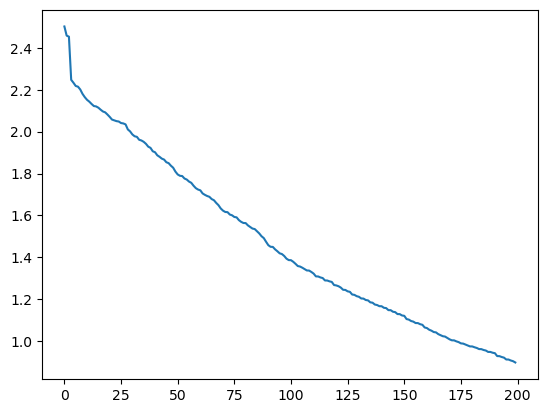

In [16]:
plt.plot(df_performance['L_tr'])

In [17]:
Y_true = torch.concatenate([torch.sin(TINY.X_train_rescale[:, 0, 0, :].sum(dim = -1, keepdim = True)*k) for k in range(1, 11)], dim = 1)

In [18]:
Y_true.shape

torch.Size([500, 10])

In [19]:
Y = torch.nn.functional.one_hot(Y_true.argmax(1)).float()

In [20]:
Y.shape

torch.Size([500, 10])

In [21]:
for i in range(10) :
    print(Y[:, i].mean())

tensor(0.1580)
tensor(0.1020)
tensor(0.0980)
tensor(0.1060)
tensor(0.0800)
tensor(0.0860)
tensor(0.0600)
tensor(0.0920)
tensor(0.0940)
tensor(0.1240)


In [20]:
MLP_model.skeleton

{0: {'size': 50}, 1: {'size': 17}, 2: {'size': 15}, 3: {'size': 10}}